# BioFaceNet

Here we implement the CNN for parsing images into specularity, shading, melanin levels, haemoglobin levels, and lighting estimation. This is done with an encoder CNN that estimates the features, and a decoder that reconstructs the image based on the features.

In [ ]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
import scipy.io as sio

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## Input

The original code does not have a link to the data used but it is most likely the data from a paper they have cited [Neural Face Editing](https://github.com/zhixinshu/NeuralFaceEditing). I have already preprocessed this data by computing the shading information from the lighting and normals, and also reversing the gamma correction on the image. Additionaly, the image pixels are zero centered. 

#### Improvements

There are several improvements to be made here. First, the data that is being used is the publicly released data from the paper. In the repository to reference 20 image files, from which they only publicly show 5 of them. If we could recover the original 20 there would be more data to use for the model. Also, the data supplied is of resolution (64, 64) when the original dataset, CelebA, has a higher resolution. It seems that [Neural Face Editing](https://github.com/zhixinshu/NeuralFaceEditing) get their data from the output of [SfSNet](https://senguptaumd.github.io/SfSNet/) from the paper's description and the fact that they use the same parameterization of lighting, normal, and shading. Regardless, we could get better results and higher resolutions if we run SfSNet on CelebA to get the cropped image, mask, and shading values to use as input for our model. Unfortunately, the original code was written in Matlab and Caffe and I could not get it to run. 

Another problem was that the [Neural Face Editing](https://github.com/zhixinshu/NeuralFaceEditing) splits shading into $3$ channels whereas our model uses a single channel shading feature. It is unknown what the original BioFaceNet author does here. I simply averaged the 3 channels to get a single channel, however there may be a better approach. The shading in this model is used as multiplier with the diffuse reflectance. This represents the raw value of the image which is put through a series of transformations to get the rgb image. However, in [Neural Face Editing](https://github.com/zhixinshu/NeuralFaceEditing) the shading is a multiplier on the final image in rgb space. Therefore, we may get better results if we take the three channel shading and invert the transformations and then take the average to get the one channel shading.

In [ ]:
images = h5py.File('drive/My Drive/data/lin_image_shading_mask_all_1.hdf5', 'r')['default']

In [ ]:
def gammaCorrection(x):
  x =  (x ** (1/2.4) * (1.055) ) - 0.055

  return x

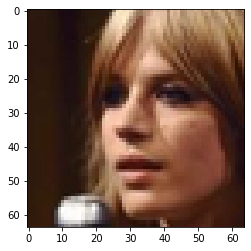

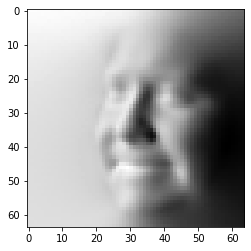

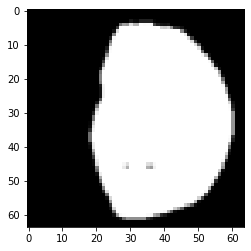

In [ ]:
# This mean pixel was subtracted on each pixel in the input

meanPixel = np.array([0.35064762, 0.21667774, 0.16786481])

idx = 0

# images has shape (N, 5, 64, 64)
# N data points. Each with rgb data in linear space, shading, and mask

x = images[idx][0:3]
x[0] += meanPixel[0]
x[1] += meanPixel[1]
x[2] += meanPixel[2]
y = images[idx][3]
z = images[idx][4]
npx = gammaCorrection(np.array(x))
npy = np.array(y) # could fix shading
npz = np.array(z)
npx = np.transpose(npx, (1, 2, 0))
plt.figure()
plt.imshow(npx)
plt.figure()
plt.imshow(npy, cmap='gray')
plt.figure()
plt.imshow(npz, cmap='gray')


In [ ]:
datanp = np.array(images)

In [ ]:
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split

device = 'cuda'
traindata_proportion = 0.9

data_tensor = torch.from_numpy(datanp).to(device)
init_dataset = TensorDataset(data_tensor) 
lengths = [int(len(init_dataset)*traindata_proportion), len(init_dataset) - 
           int(len(init_dataset)*traindata_proportion),] 
subset_train, subset_val = random_split(init_dataset, lengths)


In [ ]:
dataloaders = {
    'train': torch.utils.data.DataLoader(subset_train, batch_size=32, shuffle=True, num_workers=0),
    'val': torch.utils.data.DataLoader(subset_val, batch_size=8, shuffle=False, num_workers=0)
}

The illumination data that is used for this model is published by the BioFace net author. I use the data but we also have some sanity checks here so I can understand what the data is and where it comes from. The data is used to restrict what the model can choose to be the lighting. It must pick a linear combination of A, D, and F illuminants. Then the model computes the spectral power distrubtion from 400nm to 720nm in increments of 10nm.

The equation for A illuminant comes from [Wikipedia](https://en.wikipedia.org/wiki/Standard_illuminant#cite_note-schanda-1). We can check this matches very closely to the data provided.

The D illuminant has an a temperature parameter. In the Matlab implementation they precalculate the values for each temperature from 4000 to 25000 in increments of 1000 and interpolate during inference. Since the equations for the illuminant is fully describable I implement a function that returns the power distrubtion that is differentiable on the temperature. We use the equations from [here](http://www.brucelindbloom.com/index.html?Eqn_DIlluminant.html).

The F illuminant data is precalculated [here](http://www.rit-mcsl.org/UsefulData/Fluorescents.htm) and this matches with the data provided.

Further improvements include possibly adding more illuminant types. Also, if we could find a probability distrubution on illuminants we could bias the model into picking power distrubtions that are more likely to be found. 



In [ ]:
illAProvided = sio.loadmat("drive/My Drive/util/illumA.mat")
illAProvided = illAProvided['illumA'][0][0]

illA = illA / illA.sum()
illA = torch.tensor(illA).to(device)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """


In [ ]:
from math import e

largestDifference = 0

for i, wavelength in enumerate(range(400, 721, 10)):
    frac = (e ** (1.435 * (10 ** 7) / (2848 * 560)) - 1) / (e ** (1.435 * (10 ** 7) / (2848 * wavelength)) - 1 )
    
    r = 100 * (560 / wavelength) ** 5 * frac
    largestDifference = max(largestDifference, (illAProvided[i] - r) ** 2)

largestDifference

2.401112788002061e-07

In [ ]:
s0 = torch.Tensor([94.80,104.80,105.90,96.80,113.90,125.60,125.50,121.30,121.30,
    113.50,113.10,110.80,106.50,108.80,105.30,104.40,100.00,96.00,95.10,89.10,
    90.50,90.30,88.40,84.00,85.10,81.90,82.60,84.90,81.30,71.90,74.30,76.40,
    63.30]).to(device)

s1 = torch.Tensor([43.40,46.30,43.90,37.10,36.70,35.90,32.60,27.90,24.30,20.10,
    16.20,13.20,8.60,6.10,4.20,1.90,0.00,-1.60,-3.50,-3.50,-5.80,-7.20,-8.60,
    -9.50,-10.90,-10.70,-12.00,-14.00,-13.60,-12.00,-13.30,-12.90,-10.60
    ]).to(device)

s2 = torch.Tensor([-1.1, -0.5,-0.7,-1.2,-2.6,-2.9,-2.8,-2.6,-2.6,-1.8,-1.5,-1.3,
    -1.2,-1.0,-0.5,-0.3,0.0,0.2,0.5,2.1,3.2,4.1,4.7,5.1,6.7,7.3,8.6,9.8,10.2,
    8.3,9.6,8.5,7.0]).to(device)


def chromacity(t):
    t = t * 21000
    t = t + 4000
    
    x1 = -4.6070 * (10 ** 9) / (t ** 3) + (2.9678 * 10 ** 6) / (t ** 2) + (0.09911 * 10 ** 3) / t + 0.244063
    x2 = -2.0064 * (10 ** 9) / (t ** 3) + (1.9018 * 10 ** 6) / (t ** 2) + (0.24748 * 10 ** 3) / t + 0.237040
        
    x = (t <= 7000) * x1 + (t > 7000) * x2
        
    y = -3 * x ** 2 + 2.87 * x - 0.275
    
    return x, y

def illuminanceD(temp):
    x, y = chromacity(temp)
    
    m = 0.0241 + 0.2562 * x -0.7341 * y
    m1 = (-1.3515 - 1.7703 * x + 5.9114 * y) / m
    m2 = (0.0300 - 31.4424 * x + 30.0717 * y) / m
    
    s = s0 + m1 * s1 + m2 * s2
    return s / torch.reshape(torch.sum(s, 1), (-1, 1))

In [ ]:
# Sanity Check for D

illDData = sio.loadmat('drive/My Drive/util/illumDmeasured.mat')['illumDmeasured']
providedData = illDData / np.sum(illDData, 1).reshape(22, 1)
providedData = torch.tensor(providedData).to(device)

temps = np.reshape(np.arange(22) / 22, ((22, 1)))
generatedData = illuminanceD(torch.tensor(temps).to(device))

print(torch.max((providedData - generatedData) ** 2))

tensor(6.2608e-07, device='cuda:0', dtype=torch.float64)


In [ ]:
illF = torch.Tensor(sio.loadmat('drive/My Drive/util/illF')['illF']).to(device)[0]

print(illF)

illF = illF / torch.reshape(torch.sum(illF, 0), (1, 12))

tensor([[ 5.1700,  3.4400,  2.5700,  2.0100,  5.1000,  3.1100,  6.1500,  3.1700,
          2.5900,  1.4800,  1.2900,  1.1900],
        [ 6.1300,  3.8500,  2.7000,  1.9500,  6.0000,  3.4300,  7.3700,  3.8300,
          3.0500,  2.1200,  1.5900,  1.1200],
        [ 7.0100,  4.1900,  2.7300,  1.7600,  6.8500,  3.6800,  7.7100,  3.8600,
          2.8600,  3.7400,  2.4600,  1.0800],
        [ 8.5600,  5.0600,  3.2800,  2.1000,  8.3100,  4.4500,  9.1500,  5.0900,
          3.8200,  6.7500,  4.4900,  1.7800],
        [16.9400, 11.8100,  9.4700,  8.0300, 16.0600, 10.7400, 17.5200, 12.4200,
         10.7700, 14.8600, 12.1300,  7.9000],
        [11.3500,  6.6300,  4.2500,  2.7000, 10.9100,  5.7800, 12.0000,  8.6000,
          6.5700, 10.7600,  7.1900,  2.7100],
        [12.3700,  7.1900,  4.5900,  2.9100, 11.8300,  6.2500, 13.0800, 10.2400,
          7.8600, 10.1100,  6.7200,  2.4900],
        [13.0000,  7.5400,  4.8000,  3.0400, 12.4000,  6.5200, 13.7100, 11.3300,
          8.7500,  8.2900,  5.

## Camera Sensitivity Data

The model also predicts the sensitivity per wavelength per channel of the camera. Here I use the database from the [paper cited](http://www.gujinwei.org/research/camspec/camspec_database.txt) which has already been cleaned for us in *util/rgbCMF.mat*. I perform PCA analysis on this like in the Matlab repo. One big issue here is ambiguity since the negative of a normalized eigenvector is also a normalized eigenvector. Therefore, a projection onto the PCA vectors may differ in sign. Although, this regularly will not be a problem, the coefficients of the principal components are used in the lookup table. Therefore, I used Matlab to find the principal components and found that I had to negate the second eigenvector to make sure it corresponded to the Matlab output. Hopefully, the Matlab PCA code is determinstic and has not changed between versions, but it may be better to recompute the lookup table.

### Improvements

The original code normalize the sensitivies by the max per channel, yet in the matlab repository it is normalized by the sum. This should not make too much of a difference, since the image is white balance but it is possible that changing this could have an affect. One important thing to note here is that the BioFaceNet paper claims that two pricipal components capture 97% of the variance, but that is only true when the eigenvectors are found per channel. BioFaceNet finds the 2 eigenvector of size 99, whereas the cited paper finds 6 eigenvectors of size 33, two for each channel. We can see that we can only explain around 55% of the variance. Therfore, we could improve this by increasing the number of principal components we use.

[0.27932426 0.2678051 ]


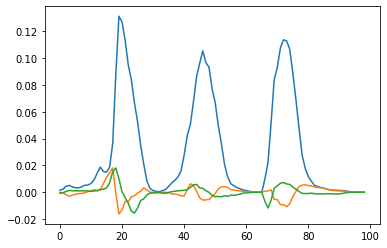

In [ ]:
from sklearn.decomposition import PCA

rgbData = sio.loadmat("drive/My Drive/util/rgbCMF.mat")
cameraSensitivityData = np.array(list(np.array(rgbData['rgbCMF'][0])))

n_components = 2

pca = PCA(n_components)

pcaComponents = np.zeros((3, 2, 33))
pcaMeans = np.zeros((3, 33))

Y = np.transpose(cameraSensitivityData, (2, 0, 1))

for camera in range(28):
    for channel in range(3):
        Y[camera,channel] /= np.sum(Y[camera,channel]) # should use max but doesn't matter since white balance divides

Y = np.resize(Y, (28, 99))

pca.fit(Y)

pcaComponents = pca.components_ * np.resize(pca.explained_variance_ ** 0.5, (n_components, 1))
pcaComponents[1] *= -1 # Done so that vector is on the same scale as matlab

# print(pca.components_.shape)
# print(pca.explained_variance_)
print(pca.explained_variance_ratio_)
# print(pca.singular_values_)
# print(pca.mean_)

plt.figure()
plt.plot(pca.mean_)
plt.plot(pcaComponents[0] )
plt.plot(pcaComponents[1] )

pcaMeans = torch.reshape(torch.tensor(pca.mean_), (1, 99)).float().to(device)
pcaComponents = torch.tensor(pcaComponents).permute(1, 0).float().to(device)

## Skin Color

Skin color is provided to us as a function of blood and melanin concentration. As a simple sanity check  we can plot this and see that we mostly get reasonable skin colors.

### Improvements

A possible improvement that could be made here is by making the skin color a differentiable function instead of a lookup table. This will increase the accuracy of the gradients. However, it is unlikely that this will be a big change since the provided matrix already is given at a high resolution

In [ ]:
Newskincolour = sio.loadmat('drive/My Drive/util/Newskincolour.mat')['Newskincolour']

Newskincolour = Newskincolour.transpose((2, 0, 1))
skinColor = torch.tensor(Newskincolour).to(device)
skinColor = torch.reshape(skinColor, (1, 33, 256, 256))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


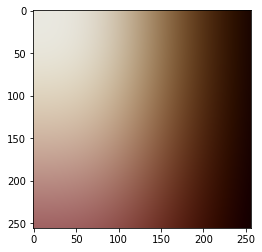

In [38]:
csTest = np.array(pcaMeans.to('cpu'))
csTest = np.reshape(csTest, (3, 33))

skinTest = sio.loadmat('drive/My Drive/util/Newskincolour.mat')['Newskincolour']

pic = skinTest @ csTest.T

pic = gammaCorrection(pic.reshape((256, 256, 3)))
plt.figure()
plt.imshow(pic)

## Color space transformations

In the model, after white balancing, there are two linear transformations to take the raw values to rgb space. One is to the standard xyz space which is dependent on camera sensitivity. The other is from xyz to rgb space which is a standardized matrix. However, it seems that the Matlab implementation applies the transpose of the xyz to rgb matrix instead. I make sure to fix this and apply the correct matrix. 

### Improvements
One possible improvement is to make the transformation matrix a differentiable function. Currently the transformation matrix is generated by the scores from PCA analsysis in a lookup table.


In [42]:
tmatrix = sio.loadmat("drive/My Drive/util/Tmatrix.mat")['Tmatrix']
tmatrix = np.transpose(tmatrix, (2, 0, 1))

tmatrix = torch.tensor(tmatrix).to(device)
tmatrix = torch.reshape(tmatrix, (1, 9, 128, 128))

In [43]:
txyx2rgb = torch.tensor([[3.2406, -1.537, -0.498],
                         [-0.968, 1.8758, 0.0415],
                         [0.0557, -0.204, 1.0570]]
                        ).to(device)

## Model

Here is the implementation of the model in pytorch. I apply the U-net architecture with skip connections as described in the paper and the Matlab implentation. There is fully pipeline desribed in the paper from spectral distribution, camera senstivity, shading estimation, white balance, and color transformations. Finally, we compute the full loss and return the loss along with the components and the features that the model predicted. 

### Improvements
The original BioFaceNet puts the weights of the illuminants in a softmax along with the temperature. It should be better to exclude the temperature out of the softmax, since it is only related to the D illuminant and apply a sigmoid on it seperately. Additionally, the paper mentions dividing the loss by the number of pixels in the mask to normalize for differences in mask sizes. This is not done in the Matlab implentations, however, but could lead to better performance. Also, I found that the given multiplier for sparcity loss was too high and caused sparcity to be 0 almost always so I lowered the multiplier to $10^{-7}$.

In [44]:
import torch.nn as nn
import torch.nn.functional as F

channels = [3, 32, 64, 128, 256, 512]
lightVectorSize = 15
n_components = 2

# 3 convolutions, batchnorms, relus for each filter size
# max pool for each filter size except last

class Unet(nn.Module):
  def __init__(self):
    super(Unet, self).__init__()
    
    self.convolutions = nn.ModuleList()
    self.encoderBatchnorms = nn.ModuleList()
    size = 64
    for i in range(1, len(channels)):
        self.convolutions.append(nn.Conv2d(channels[i - 1], channels[i], 3, padding = 1))
        self.encoderBatchnorms.append(nn.BatchNorm2d(channels[i]))
        
        self.convolutions.append(nn.Conv2d(channels[i], channels[i], 3, padding = 1))
        self.encoderBatchnorms.append(nn.BatchNorm2d(channels[i]))
        
        self.convolutions.append(nn.Conv2d(channels[i], channels[i], 3, padding = 1))
        self.encoderBatchnorms.append(nn.BatchNorm2d(channels[i]))
        
        if i != len(channels) - 1:
            size //= 2
            
    self.low_resolution = size
    
    self.fc1 = nn.Linear(channels[-1] * size * size, channels[-1])
    self.batchnorm1 = nn.BatchNorm1d(channels[-1])
    self.fc2 = nn.Linear(channels[-1], channels[-1])
    self.batchnorm2 = nn.BatchNorm1d(channels[-1])
    self.fc3 = nn.Linear(channels[-1], lightVectorSize + n_components)
    
    self.decoderConvolutions = nn.ModuleList()
    self.decoderBatchnorms = nn.ModuleList()
    
    for outClass in range(4):
        convs = nn.ModuleList()
        bns = nn.ModuleList()
        for i in reversed(range(1, len(channels) - 1)):
            size *= 2

            convs.append(nn.Conv2d(channels[i] + channels[i + 1], channels[i], 3, padding = 1))
            bns.append(nn.BatchNorm2d(channels[i]))
            convs.append(nn.Conv2d(channels[i], channels[i], 3, padding = 1))
            bns.append(nn.BatchNorm2d(channels[i]))
            convs.append(nn.Conv2d(channels[i], channels[i], 3, padding = 1))
            bns.append(nn.BatchNorm2d(channels[i]))

        convs.append(nn.Conv2d(channels[1], 1, 3, padding = 1))
        
        self.decoderConvolutions.append(convs)
        self.decoderBatchnorms.append(bns)
    
  def forward(self, x):
    image = x[:,:3,:,:] # (B, 5, 64, 64) -> (B, 3, 64, 64)
    shading = x[:,3,:,:] # (B, 5, 64, 64) -> (B, 1, 64, 64)
    mask = x[:,4,:,:] # (B, 5, 64, 64) -> (B, 1, 64, 64)
    
    skipValues = []

    ########### Encoding ###########
    for convIndex in range(len(self.convolutions)):
        image = self.convolutions[convIndex](image)
        image = self.encoderBatchnorms[convIndex](image)
        image = F.relu(image)
        
        if convIndex % 3 == 2 and convIndex != len(self.convolutions) - 1:
            skipValues.append(torch.clone(image))
            image = F.max_pool2d(image, 2)
            
    skipValues.reverse()
            
    ########### Fully Connected Layer ###########
    # (B, channels[-1], low_resolution, low_resolution) -> (B, channels[-1], * low_resolution *low_resolution)
    lighting = torch.reshape(image, (-1, self.low_resolution * self.low_resolution * channels[-1]))
    lighting = self.fc1(lighting)
    lighting = self.batchnorm1(lighting)
    lighting = F.relu(lighting)
    lighting = self.fc2(lighting)
    lighting = self.batchnorm2(lighting)
    lighting = F.relu(lighting)
    lighting = self.fc3(lighting)
    
    features = []

    ########### Decoding ###########

    for out in range(4):
        feature = torch.clone(image)
        
        for i in range(len(self.decoderConvolutions[out]) - 1):
            if i % 3 == 0:
                feature = F.interpolate(feature, scale_factor = 2)
                feature = torch.cat((feature, skipValues[i // 3]), 1)
                
            feature = self.decoderConvolutions[out][i](feature)
            feature = self.decoderBatchnorms[out][i](feature)
            feature = F.relu(feature)
            
        feature = self.decoderConvolutions[out][-1](feature)
        features.append(feature)
    
    lighting_parameters = lighting[:,:lightVectorSize]
    b = lighting[:,lightVectorSize:]
    
    mel, blood, shade, spec = features

    ########### Scaling ########### 
    
    lighting_parameters = F.softmax(lighting_parameters, 1) # possibly exclude colortemp out of softmax
    weightA = lighting_parameters[:,0]
    weightA = torch.reshape(weightA, (-1, 1))
    weightD = lighting_parameters[:,1]
    weightD = torch.reshape(weightD, (-1, 1))
    fWeights = lighting_parameters[:,2:14]
    colorTemp = lighting_parameters[:,14]
    colorTemp = torch.reshape(colorTemp, (-1, 1))
    
    b = 6 * torch.sigmoid(b) - 3
    
    mel = -2 * torch.sigmoid(mel) + 1
    blood = -2 * torch.sigmoid(blood) + 1
    shade = torch.exp(shade)
    spec = torch.exp(spec)

    ########### Illumination ###########
    
    aLightVector = weightA * illA
    dLightVector = weightD * illuminanceD(colorTemp)
    fLightVector = F.linear(fWeights, illF)
    
    e = aLightVector + dLightVector + fLightVector
    eSums = torch.reshape(torch.sum(e, 1), (-1, 1))
    
    e = e / eSums
    
    S = F.linear(b, pcaComponents)
    S += pcaMeans
    
    S = F.relu(S)
    
    S = torch.reshape(S, (-1, 3, 33))
    
    lightColor = S * torch.reshape(e, (-1, 1, 33))
    lightColor = torch.sum(S, 2)

    ########### Specularities ###########
    
    spec = spec * torch.reshape(lightColor, (-1, 3, 1, 1))

    ########### Diffuse ###########
    
    bioPhysicalLayer = torch.cat((mel, blood), 1).permute((0, 2, 3, 1))
    skinColorGrid = skinColor.repeat((bioPhysicalLayer.shape[0], 1, 1, 1))
    r_total = F.grid_sample(skinColorGrid, bioPhysicalLayer)
    
    spectra = r_total * torch.reshape(e, (-1, 33, 1, 1))
    spectra = torch.reshape(spectra, (-1, 1, 33, 64, 64))
    S = torch.reshape(S, (-1, 3, 33, 1, 1))

    diffuse = torch.sum(spectra* S, 2)
    diffuse = shade * diffuse

    raw = diffuse + spec

    ########### Camera Transformation ###########

    wb = raw / torch.reshape(lightColor, (-1, 3, 1, 1))

    tMatrixGrid = tmatrix.repeat((wb.shape[0], 1, 1, 1))
    bIndex = torch.reshape(b / 3, (-1, 1, 1, 2))

    ts = F.grid_sample(tMatrixGrid, bIndex)
    ts = torch.reshape(ts, (-1,9, 1, 1))

    ix = ts[:, 0, :, :] * wb[:,0,:,:] + ts[:, 3, :, :] * wb[:,1,:,:] + ts[:, 6, :, :] * wb[:,2,:,:]
    iy = ts[:, 1, :, :] * wb[:,0,:,:] + ts[:, 4, :, :] * wb[:,1,:,:] + ts[:, 7, :, :] * wb[:,2,:,:]
    iz = ts[:, 2, :, :] * wb[:,0,:,:] + ts[:, 5, :, :] * wb[:,1,:,:] + ts[:, 8, :, :] * wb[:,2,:,:]
    
    ix = torch.reshape(ix, (-1, 1, 64, 64))
    iy = torch.reshape(iy, (-1, 1, 64, 64))
    iz = torch.reshape(iz, (-1, 1, 64, 64))
    
    xyz = torch.cat((ix, iy, iz), 1)

    xyz = xyz.permute((0, 2, 3, 1))
    rgb = F.linear(xyz, txyx2rgb)
    rgb = rgb.permute((0, 3, 1, 2))

    rgb = F.relu(rgb)

    shade = torch.reshape(shade, (-1, 64, 64))

    ########### Loss ###########

    scale = torch.sum(shade * shading * mask, (1, 2)) / torch.sum(shade * shade * mask, (1, 2))


    scaledShading = torch.reshape(scale, (-1, 1, 1)) * shade
    alpha = (shading - scaledShading) * mask

    priorLoss = torch.sum(b ** 2) * 1e-4 / x.shape[0]

    originalImage = torch.clone(x[:,:3,:,:])
    originalImage[:,0,:,:] += 0.35064762
    originalImage[:,1,:,:] += 0.21667774
    originalImage[:,2,:,:] += 0.16786481
    

    delta = ((originalImage - rgb) ** 2) * torch.reshape(mask, (-1, 1, 64, 64))
    appearanceLoss = torch.sum(delta ** 2 / (64 * 64)) * 255 * 255 * 1e-3 / x.shape[0]
    # Matlab implementation has image in (0 - 255) so we scale appropriately

    shadingLoss = torch.sum(alpha ** 2) * 1e-5 / x.shape[0]

    # Paper mentions divide by size of mask but not in implementation
    # computing on spec sparsity loss after lightColor transformation

    sparcityLoss = torch.sum(spec) * 1e-7 / x.shape[0] # Change to 1e-7

    totalLoss = priorLoss + appearanceLoss + shadingLoss + sparcityLoss

    return totalLoss, priorLoss, appearanceLoss, shadingLoss, sparcityLoss, rgb, shade, spec, mel, blood
    



    
    
    



## Training

Here I train the model with 100 epochs. There is a batch size of 32 and I have split the data into 90% training data and 10% validation data. After each epoch we display the features produced by the model on a random data point in the validation set.

### Improvements

After a few epochs we get good reconstruction loss. However, it is hard to verify the other components of the loss and their accuracy. One improvement that could be made is to also train on data with blood, melanin, or shading given. We could also train on synthetic data, similar to SfSNet. In that paper they use 3d models to generate images so that the ground truth is available to them

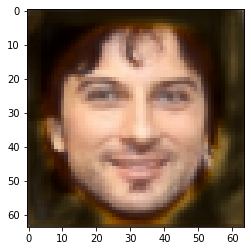

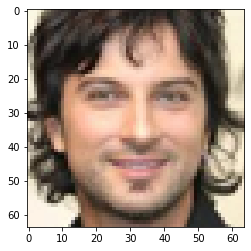

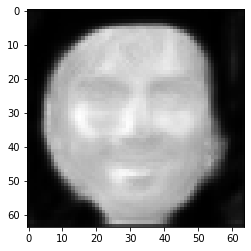

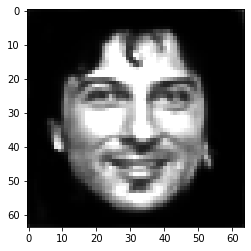

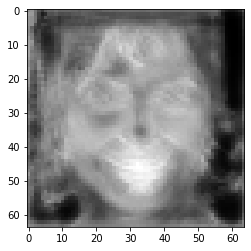

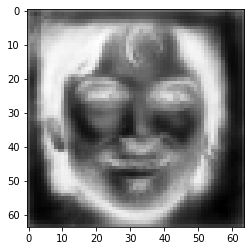

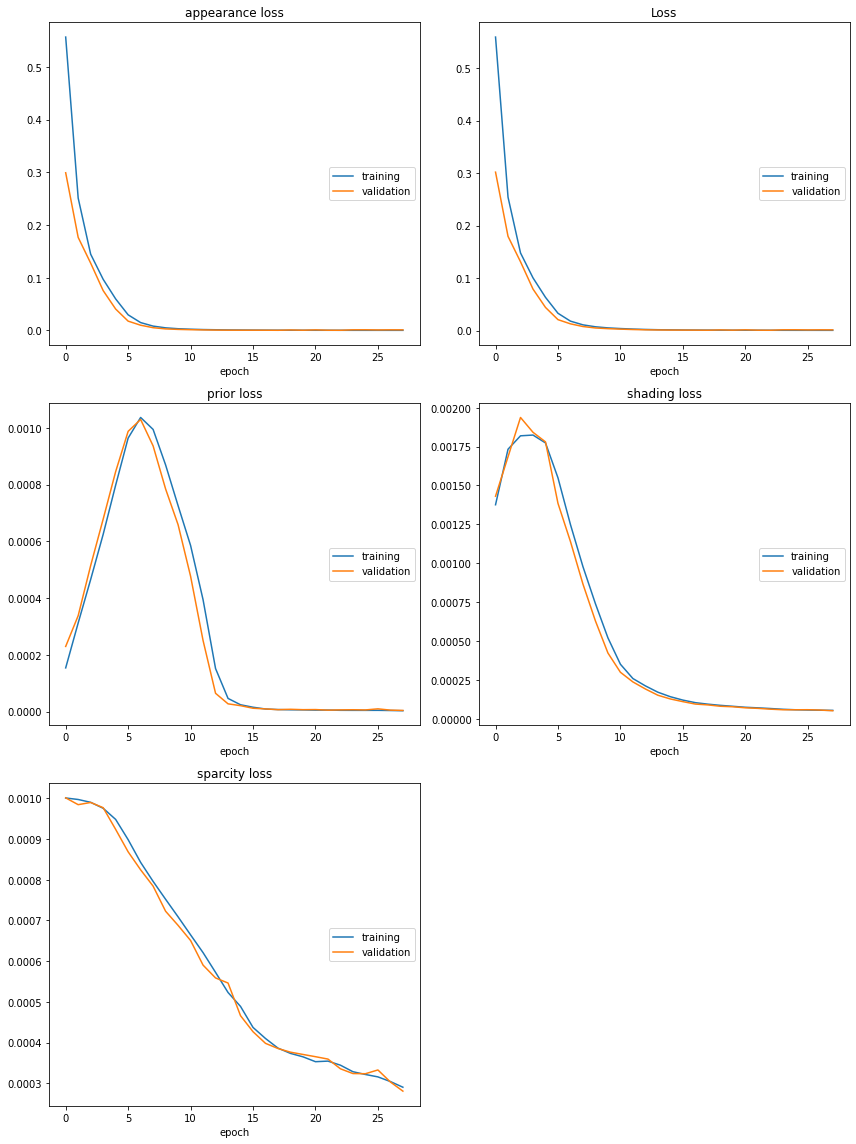

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


appearance loss
	training         	 (min:    0.000, max:    0.556, cur:    0.000)
	validation       	 (min:    0.000, max:    0.299, cur:    0.001)
Loss
	training         	 (min:    0.001, max:    0.559, cur:    0.001)
	validation       	 (min:    0.001, max:    0.302, cur:    0.001)
prior loss
	training         	 (min:    0.000, max:    0.001, cur:    0.000)
	validation       	 (min:    0.000, max:    0.001, cur:    0.000)
shading loss
	training         	 (min:    0.000, max:    0.002, cur:    0.000)
	validation       	 (min:    0.000, max:    0.002, cur:    0.000)
sparcity loss
	training         	 (min:    0.000, max:    0.001, cur:    0.000)
	validation       	 (min:    0.000, max:    0.001, cur:    0.000)
Epoch 28/99
----------
LR 1e-05


In [ ]:
!pip install livelossplot --quiet
from livelossplot import PlotLosses
import time
from random import randint

SAVED_WEIGHTS = False

model = Unet().to(device)

if SAVED_WEIGHTS:
  model.load_state_dict(torch.load('drive/My Drive/working/model.pth'))

liveloss = PlotLosses()
smallestLoss = 1e9

num_epochs = 100

optimizer = torch.optim.Adam(model.parameters(), lr = 1e-5, weight_decay=0)

for epoch in range(num_epochs):
  print('Epoch {}/{}'.format(epoch, num_epochs - 1))
  print('-' * 10)
  logs = {}

  # let every epoch go through one training cycle and one validation cycle
  # TRAINING AND THEN VALIDATION LOOP...
  for phase in ['train', 'val']:
    train_loss = 0
    prior_train_loss = 0
    appearance_train_loss = 0
    shading_train_loss = 0
    prior_train_loss = 0
    sparcity_train_loss = 0
    
    total = 0
    batch_idx = 0

    start_time = time.time()

    if phase == 'train':
      for param_group in optimizer.param_groups:
        print("LR", param_group['lr']) # print out the learning rate
      model.train()  # Set model to training mode
    else:
      model.eval()   # Set model to evaluate mode
    
    for inputs in dataloaders[phase]:
      inputs = inputs[0]
      inputs = inputs.to(device)
      batch_idx += 1
      
      optimizer.zero_grad()
      
      with torch.set_grad_enabled(phase == 'train'):
        loss, priorLoss, appearanceLoss, shadingLoss, sparcityLoss, *maps = model(inputs)
        
        if phase == 'train':
          loss.backward()
          optimizer.step()

        train_loss += loss            
        appearance_train_loss += appearanceLoss
        shading_train_loss += shadingLoss
        prior_train_loss += priorLoss
        sparcity_train_loss += sparcityLoss           


    prefix = ''
    if phase == 'val':
        prefix = 'val_'
        if (train_loss.item()) < smallestLoss:
            torch.save(model.state_dict(), 'drive/My Drive/working/model.pth')
            smallestLoss = train_loss.item()
    
    logs[prefix + 'loss'] = train_loss.item()/(batch_idx)
    logs[prefix + 'appearance loss'] = appearance_train_loss.item()/(batch_idx)
    logs[prefix + 'shading loss'] = shading_train_loss.item()/(batch_idx)
    logs[prefix + 'prior loss'] = prior_train_loss.item()/(batch_idx)
    logs[prefix + 'sparcity loss'] = sparcity_train_loss.item()/(batch_idx)

  liveloss.update(logs)
  liveloss.send()

  with torch.set_grad_enabled(False):
    model.eval()
    randIndex = randint(0, len(subset_val) - 1)

    inputData = torch.reshape(subset_val[randIndex][0], (1, 5, 64, 64))

    *losses, rgb, shade, spec, mel, blood = model(inputData)
    originalImage = torch.clone(inputData[0,:3,:,:]).to('cpu')
    originalImage[0] += 0.35064762
    originalImage[1] += 0.21667774
    originalImage[2] += 0.16786481

    rgb = gammaCorrection(rgb[0]).to('cpu')
    originalImage = gammaCorrection(originalImage)

    rgb = np.array(rgb)
    rgb = np.transpose(rgb, (1, 2, 0))

    originalImage = np.array(originalImage)
    originalImage = np.transpose(originalImage, (1, 2, 0))

    spec = np.array(spec[0].to('cpu'))
    spec = np.transpose(spec, (1, 2, 0))


    plt.figure()
    plt.imshow(rgb)

    plt.figure()
    plt.imshow(originalImage)

    plt.figure()
    plt.imshow(shade[0].to('cpu'), cmap='gray')

    plt.figure()
    plt.imshow(spec)

    plt.figure()
    plt.imshow(blood[0][0].to('cpu'), cmap='gray')

    plt.figure()
    plt.imshow(mel[0][0].to('cpu'), cmap='gray')

  



/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3829: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for

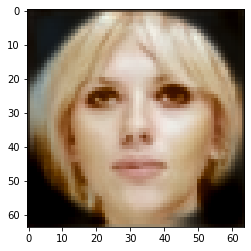

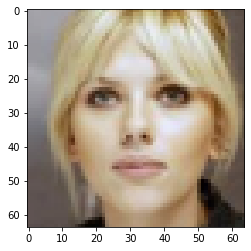

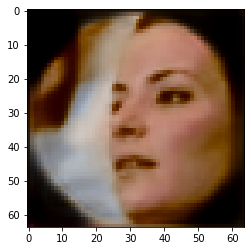

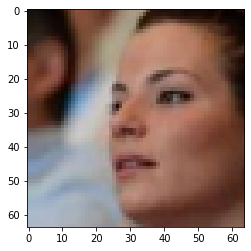

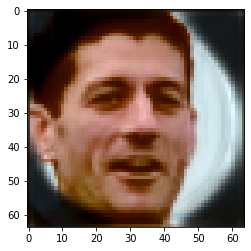

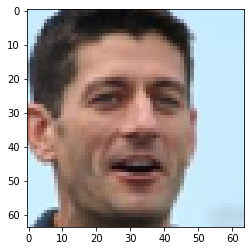

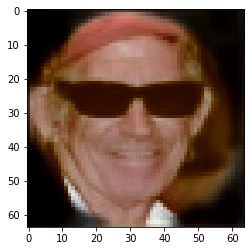

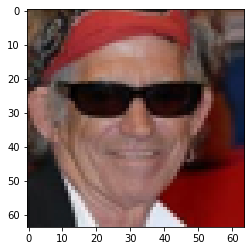

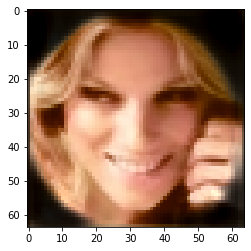

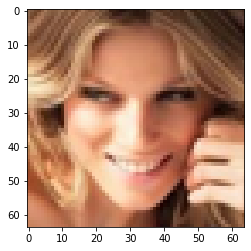

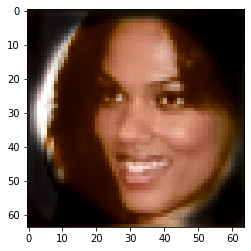

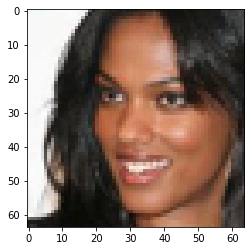

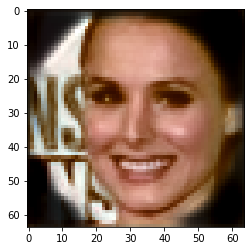

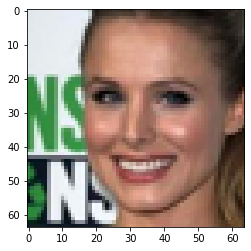

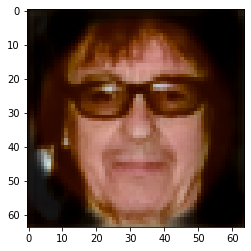

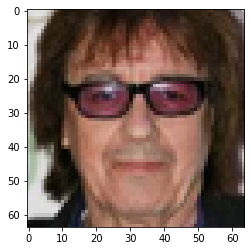

In [ ]:
model.load_state_dict(torch.load('drive/My Drive/working/model.pth'))

for inputs in dataloaders['val']:
  inputs = inputs[0]
  inputs = inputs.to(device)

  with torch.set_grad_enabled(False):
    outputs = model(inputs)

    images = outputs[5].to('cpu')

    originalImage = torch.clone(inputs[:,:3,:,:]).to('cpu')
    originalImage[:,0,:,:] += 0.35064762
    originalImage[:,1,:,:] += 0.21667774
    originalImage[:,2,:,:] += 0.16786481

    for image, truth in zip(images, originalImage):
      image = gammaCorrection(image)
      truth = gammaCorrection(truth)

      npimage = np.array(image)
      npimage = np.transpose(npimage, (1, 2, 0))

      nptruth = np.array(truth)
      nptruth = np.transpose(nptruth, (1, 2, 0))


      plt.figure()
      plt.imshow(npimage)

      plt.figure()
      plt.imshow(nptruth)

    


  break

In [ ]:
totalParams = 0

for p in net.parameters():
    totalParams += p.numel()
    
totalParams